pylandstats already installed.
openpyxl already installed.
rasterio already installed.
folium already installed.
pandas already installed.
numpy already installed.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/My Drive/Colab Notebooks
TIF files found: ['/content/drive/My Drive/Colab Notebooks/bairros_2021.tif']
XLSX files found: ['/content/drive/My Drive/Colab Notebooks/Codigos-da-legenda-colecao-8.xlsx']
Input raster: /content/drive/My Drive/Colab Notebooks/bairros_2021.tif
Color Excel: /content/drive/My Drive/Colab Notebooks/Codigos-da-legenda-colecao-8.xlsx
Output file: /content/drive/My Drive/Colab Notebooks/bairros_2021_metrics_output.csv
Map saved to /content/drive/My Drive/Colab Notebooks/bairros_2021_map_output.html
Metrics saved to /content/drive/My Drive/Colab Notebooks/bairros_2021_metrics_output.csv
Process completed successfully.


/usr/local/lib/python3.10/dist-packages/pylandstats/landscape.py:1078: RuntimeWarning: Class 11 has less than 2 patches. Euclidean-nearest-neighbor might contain nan values
  warnings.warn(



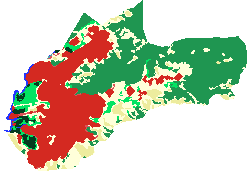

In [19]:
import subprocess  # Import subprocess module to run shell commands

# Function to check and install necessary packages
def setup_environment():
    def check_install(package):
        try:
            __import__(package)  # Try to import the package
            print(f'{package} already installed.')  # Print message if already installed
        except ImportError:
            print(f'{package} not installed. Installing {package}...')  # Print message if not installed
            subprocess.check_call(['pip', 'install', package])  # Use subprocess to install package

    # List of necessary packages
    packages = ['pylandstats', 'openpyxl', 'rasterio', 'folium', 'pandas', 'numpy']

    # Check and install each package
    for package in packages:
        check_install(package)

# Execute setup_environment function to ensure required packages are installed
setup_environment()

import os  # Import os for file path operations
from google.colab import drive  # Import drive to mount Google Drive
import pylandstats as pls  # Import pylandstats for landscape analysis
import pandas as pd  # Import pandas for data manipulation
import rasterio  # Import rasterio for raster data handling
import folium  # Import folium for interactive maps
import numpy as np  # Import numpy for numerical operations
from matplotlib.colors import ListedColormap  # Import ListedColormap for custom colormaps
import glob  # Import glob for file pattern matching

# Mount Google Drive
drive.mount('/content/drive')

# Function to calculate and save landscape metrics and plot the raster interactively
def calculate_save_metrics_and_plot(input_file, output_file, color_excel, nodata_value=0):
    # Load raster data and calculate metrics using pylandstats
    ls = pls.Landscape(input_file, nodata=nodata_value)
    metrics_df = ls.compute_class_metrics_df().to_csv(output_file, sep='\t', encoding='utf-8')

    # Read color legend Excel file using pandas
    color_df = pd.read_excel(color_excel)
    color_map = {row['Class_ID']: row['Color'] for _, row in color_df.iterrows()}

    # Load raster data using rasterio
    with rasterio.open(input_file) as src:
        bounds = src.bounds
        raster_array = src.read(1)
        transform = src.transform

    # Create a custom colormap based on colors from the legend
    unique_classes = np.unique(raster_array)
    colormap = np.zeros((256, 4), dtype=int)
    for class_id, color in color_map.items():
        hex_color = color.lstrip('#')
        rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))
        colormap[class_id] = (*rgb, 255)  # Add alpha channel

    colormap = ListedColormap([tuple(c / 255 for c in colormap[i]) for i in range(256)])

    # Create folium map centered on raster data bounds
    m = folium.Map([((bounds.top + bounds.bottom) / 2), ((bounds.left + bounds.right) / 2)], zoom_start=10)

    # Add raster data overlay to the map
    folium.raster_layers.ImageOverlay(
        image=raster_array,
        bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
        colormap=lambda x: colormap.colors[x],
        opacity=0.6
    ).add_to(m)

    # Add zoom control to the map
    folium.LayerControl().add_to(m)

    # Display the map
    return m

# Get the current directory where this notebook is located
current_directory = os.getcwd()
print(f'Current directory: {current_directory}')

# Find the raster and Excel files in the current directory
tif_files = glob.glob(os.path.join(current_directory, '*.tif'))
xlsx_files = glob.glob(os.path.join(current_directory, '*.xlsx'))

print(f'TIF files found: {tif_files}')
print(f'XLSX files found: {xlsx_files}')

if not tif_files:
    raise FileNotFoundError("No .tif files found in the current directory.")
else:
    input_raster = tif_files[0]

if not xlsx_files:
    raise FileNotFoundError("No .xlsx files found in the current directory.")
else:
    color_excel = xlsx_files[0]

# Define the output file name based on the input raster file name
raster_base_name = os.path.splitext(os.path.basename(input_raster))[0]
output_file = os.path.join(current_directory, f'{raster_base_name}_metrics_output.csv')

print(f'Input raster: {input_raster}')
print(f'Color Excel: {color_excel}')
print(f'Output file: {output_file}')

# Call the function to perform calculations, save metrics, and plot raster
m = calculate_save_metrics_and_plot(input_raster, output_file, color_excel)

# Save the interactive map as HTML
html_output = os.path.join(current_directory, f'{raster_base_name}_map_output.html')
m.save(html_output)
print(f'Map saved to {html_output}')

# Print success message after saving metrics to CSV
print(f'Metrics saved to {output_file}')

# Print completion message
print('Process completed successfully.')

# Display the interactive map in Jupyter Notebook or Google Colab
m
